In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

%cd ..
from utils import *

/scratch2/jsalle/ObsScaling


In [3]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [4]:
from pathlib import Path
import glob
import pandas as pd
import json


def load_acc_mmlu_subtasks(folder="/scratch2/jsalle/ObsScaling/eval_results/output"):

    mmlu_df = pd.DataFrame()

    for filename in Path(folder).rglob( '*.json' ):

        f = open(filename)
        jsonf = json.load(f)
        results = jsonf['results']
        
        temp_df = pd.DataFrame(columns=['Model']+[t for t in results.keys()])

        for task in results.keys():
            temp_df.at[0,task] = results[task]['acc,none']

        temp_df['Model'] = jsonf['model_name']
        mmlu_df = pd.concat([mmlu_df, temp_df], ignore_index=True, axis=0)

    mmlu_df.drop_duplicates(subset=['Model'], inplace=True)
    return mmlu_df


def merge_mmlu_sutasks_with_init_df(base_llm_eval_with_post_training,
                                    mmlu_df):
    merged_eval = pd.merge(base_llm_eval_with_post_training, mmlu_df, on='Model', how='outer')
    merged_eval = merged_eval[merged_eval['Model'].isin(mmlu_df['Model'])]

    # Remove also Qwen2 for now because ot was not evaluated on GSM8K, ARC-C, etc.
    merged_eval = merged_eval[~merged_eval['Model'].str.contains('Qwen2')]
    return merged_eval

In [5]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()
eval_result_path = "./eval_results/base_llm_post_training_eval.csv"
post_training_eval = pd.read_csv(eval_result_path)

# Merge 
base_llm_eval_with_post_training = pd.merge(base_llm_benchmark_eval, post_training_eval, on="Model")

mmlu_df = load_acc_mmlu_subtasks()
merged_eval = merge_mmlu_sutasks_with_init_df(base_llm_eval_with_post_training, mmlu_df)

In [6]:
mmlu_subtasks = [t for t in mmlu_df.columns if t != 'Model']

NONGSM_METRIC_LIST = [ 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'XWinograd', 'HumanEval'] + mmlu_subtasks
#['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'XWinograd', 'HumanEval']

NONGSM_PCA_PREPROCESS_KWARGS = DEFAULT_PCA_PREPROCESS_KWARGS.copy()
NONGSM_PCA_PREPROCESS_KWARGS["imputation_metrics"] = NONGSM_METRIC_LIST
NONGSM_PCA_PREPROCESS_KWARGS["pca_metrics"] = NONGSM_METRIC_LIST


SCALING_SETUP_KWARGS = {
    # Data preprocessing: PCA imputation and extraction
    **NONGSM_PCA_PREPROCESS_KWARGS,  # exclude GSM to avoid making the task trivial, e.g., using GSM to predict GSM
    
    # Non-lineariy: sigmoid with parametrized scale and shift
    "nonlinearity": "sigmoid-parametric", 

    # Cutoff: 8.4E22 FLOPs corresponding to LLama-2 7B
    #"split_method": None,
    #"cutoff_threshold": 84,

    # Model families: include all we have evaled
    #"df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
    "df_groupby": 'Model Family',  # group markers by model family
    "ref_model_family": 'Llama-2',

    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
}

PLOT_X_METRICS_LIST = [MODEL_SIZE_METRIC, TRAINING_FLOPS_METRIC, PC_METRIC_NUM_3]   # plot scaling comparison w.r.t. model size, training FLOPs, and 3 PCs

In [7]:
## GSM8K eval metrics with CoT and self-consistency
GSM8K_METHOD_SCALING_COT_METRIC_MAP = {
    'gsm8k_5_exact_match,flexible-extract': "Naive + Greedy",
    'gsm8k_cot_8_exact_match,flexible-extract': "CoT + Greedy",
}

GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP = {
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': "CoT + 1 Sample",
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': "CoT + SC + 5 Samples",
}

GSM8K_METHOD_SCALING_ORIG_METRIC_MAP = {
    **GSM8K_METHOD_SCALING_COT_METRIC_MAP,
    **GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP,
}

GSM8K_COT_SCALING_METRICS = list(GSM8K_METHOD_SCALING_COT_METRIC_MAP.keys())
GSM8K_SELFCONS_SCALING_METRICS = list(GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP.keys())

GSM8K_METHOD_SCALING_METRICS = [
    'gsm8k_5_exact_match,flexible-extract',
    'gsm8k_cot_8_exact_match,flexible-extract',
    # 'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract',
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract',
]

color_palette = sns.color_palette()

GSM8K_METHOD_SCALING_COLOR_MAP = {
    'gsm8k_5_exact_match,flexible-extract': color_palette[1],
    'gsm8k_cot_8_exact_match,flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': color_palette[2],
}


GSM8K_SETUP_SPECIFIC_KWARGS = {}
for e in GSM8K_METHOD_SCALING_METRICS:
    GSM8K_SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": GSM8K_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

    if e != "gsm8k_5_exact_match,flexible-extract":
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["plot_adjust_kwargs"].update({"ylim": [-0.03, 0.97]})
    if e in ["gsm8k_5_exact_match,flexible-extract"]:
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["grace_range_ratios"] = [0.05, 0.12]


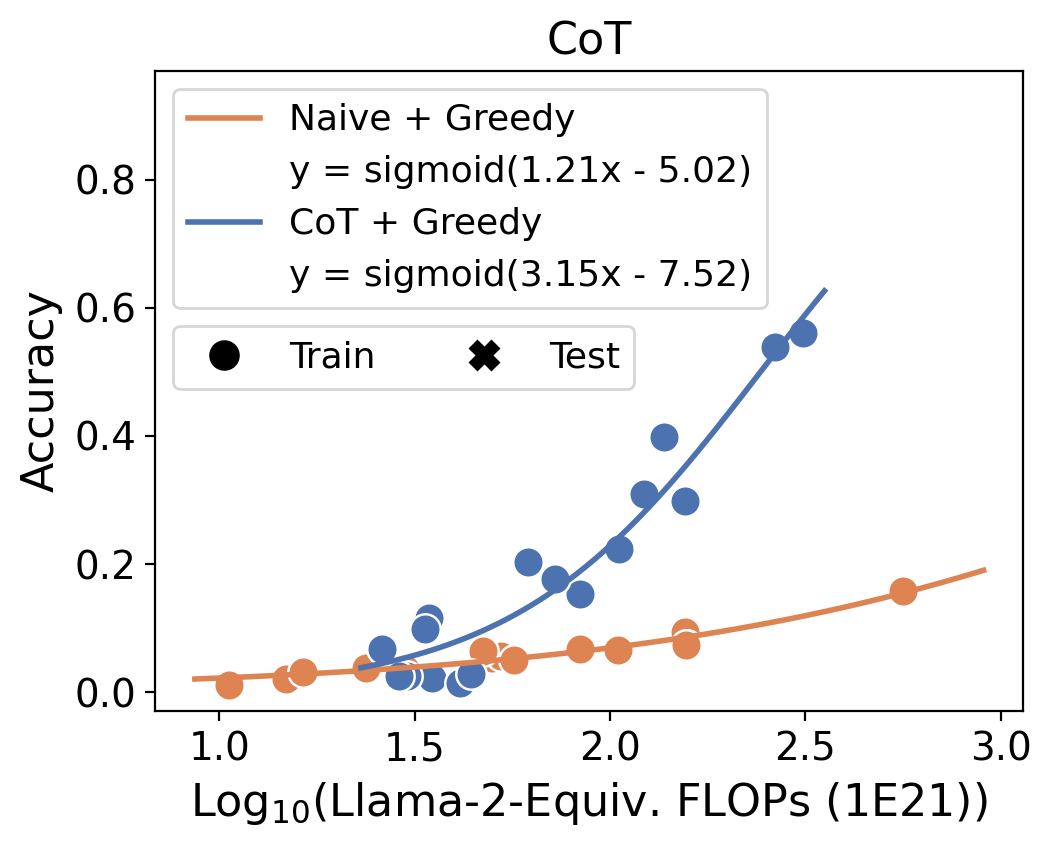

In [8]:
fig, fit_results = plot_scaling_comparison_multi_metrics(
    merged_eval, 
    y_metric_list=GSM8K_COT_SCALING_METRICS, 
    x_metrics_list=[PC_METRIC_NUM_3], 
    analysis_setup_kwargs=SCALING_SETUP_KWARGS, 
    y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
    plot_title="CoT"
)

Missing values in training data: 0.59%


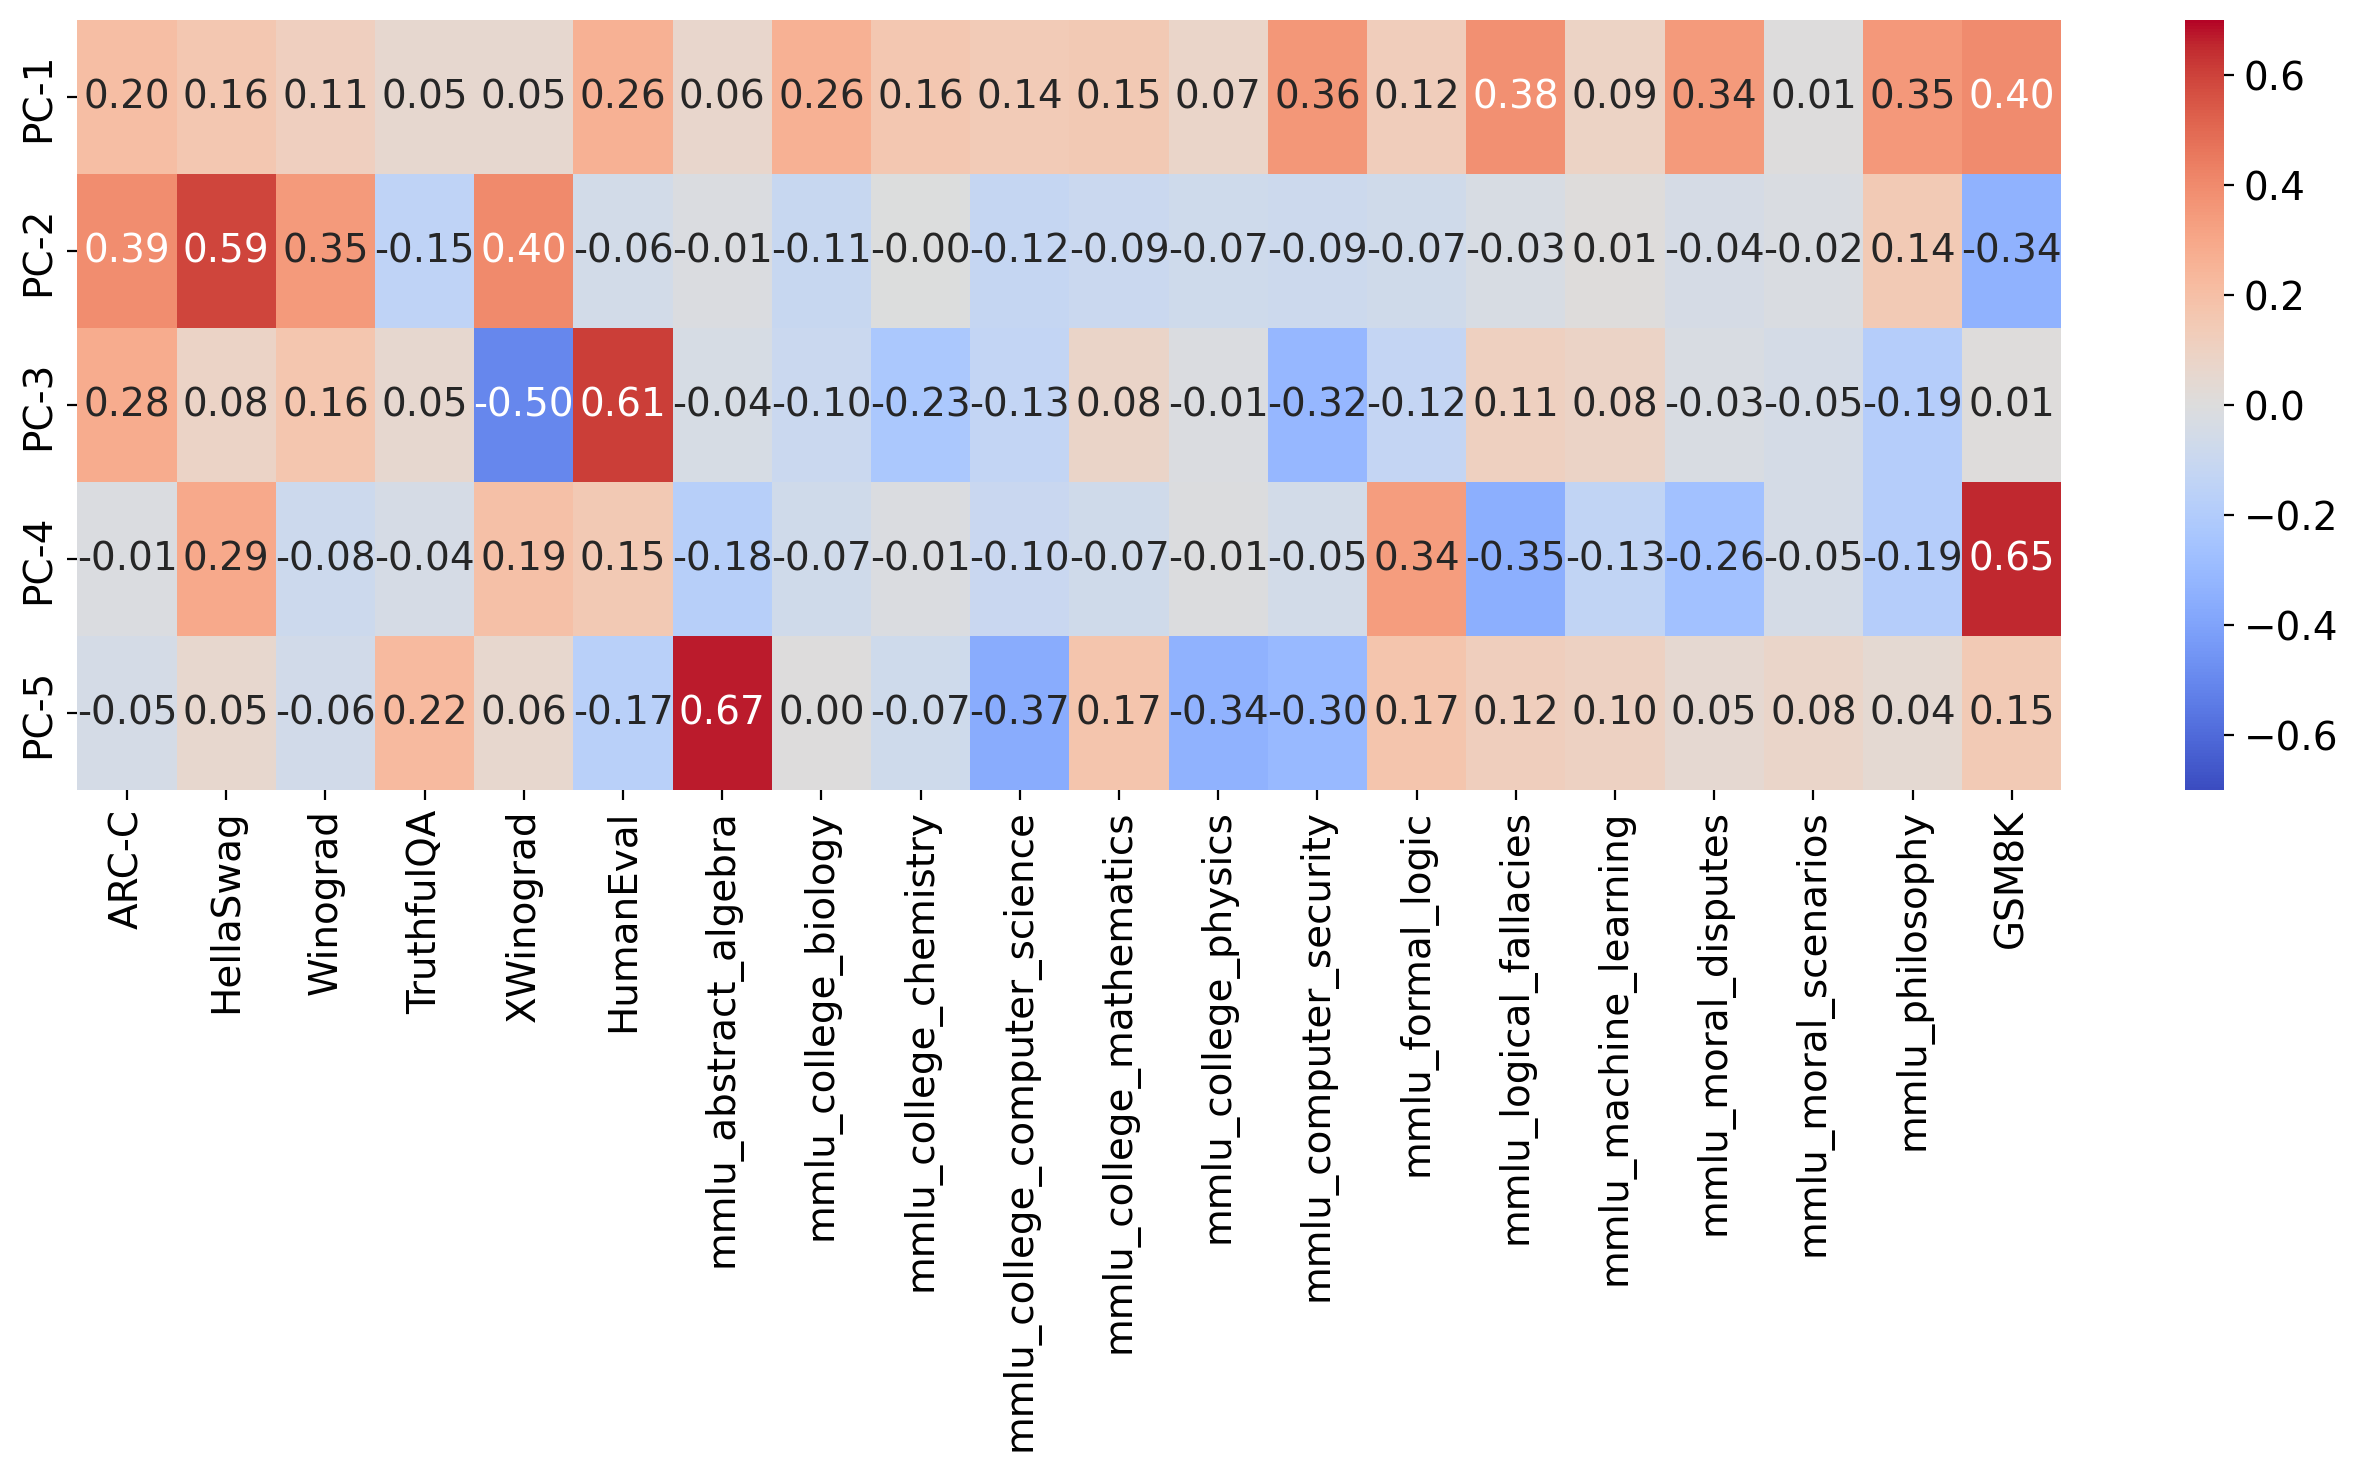

In [9]:
pca_impute_metrics = NONGSM_METRIC_LIST + ['GSM8K']
metric_df = merged_eval[pca_impute_metrics]

impute_kwargs = DEFAULT_PCA_PREPROCESS_KWARGS['imputation_kwargs'].copy()
impute_kwargs['verbose'] = True
imputed_metric_df, _ = pca_impute(metric_df, **impute_kwargs)

pca, imputed_metric_pc, _ = perform_pca(imputed_metric_df, **DEFAULT_PCA_PREPROCESS_KWARGS['pca_kwargs']) 

fig, ax = plt.subplots(figsize=(16, 5))

# nicer visualization: make the PC dims mostly "postively" correlated to model performance
vis_weights = pca.components_.copy()
for idx in [1, 3, 4]:
    vis_weights[idx] *= -1

sns.heatmap(vis_weights, annot=True, fmt='.2f', cmap='coolwarm', ax=ax, vmin=-0.7, vmax=0.7)
ax.set_yticklabels(imputed_metric_pc.columns)
ax.set_xticklabels(pca_impute_metrics, rotation=90)

plt.show()

/scratch2/jsalle/ObsScaling/utils/plot.py:809: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


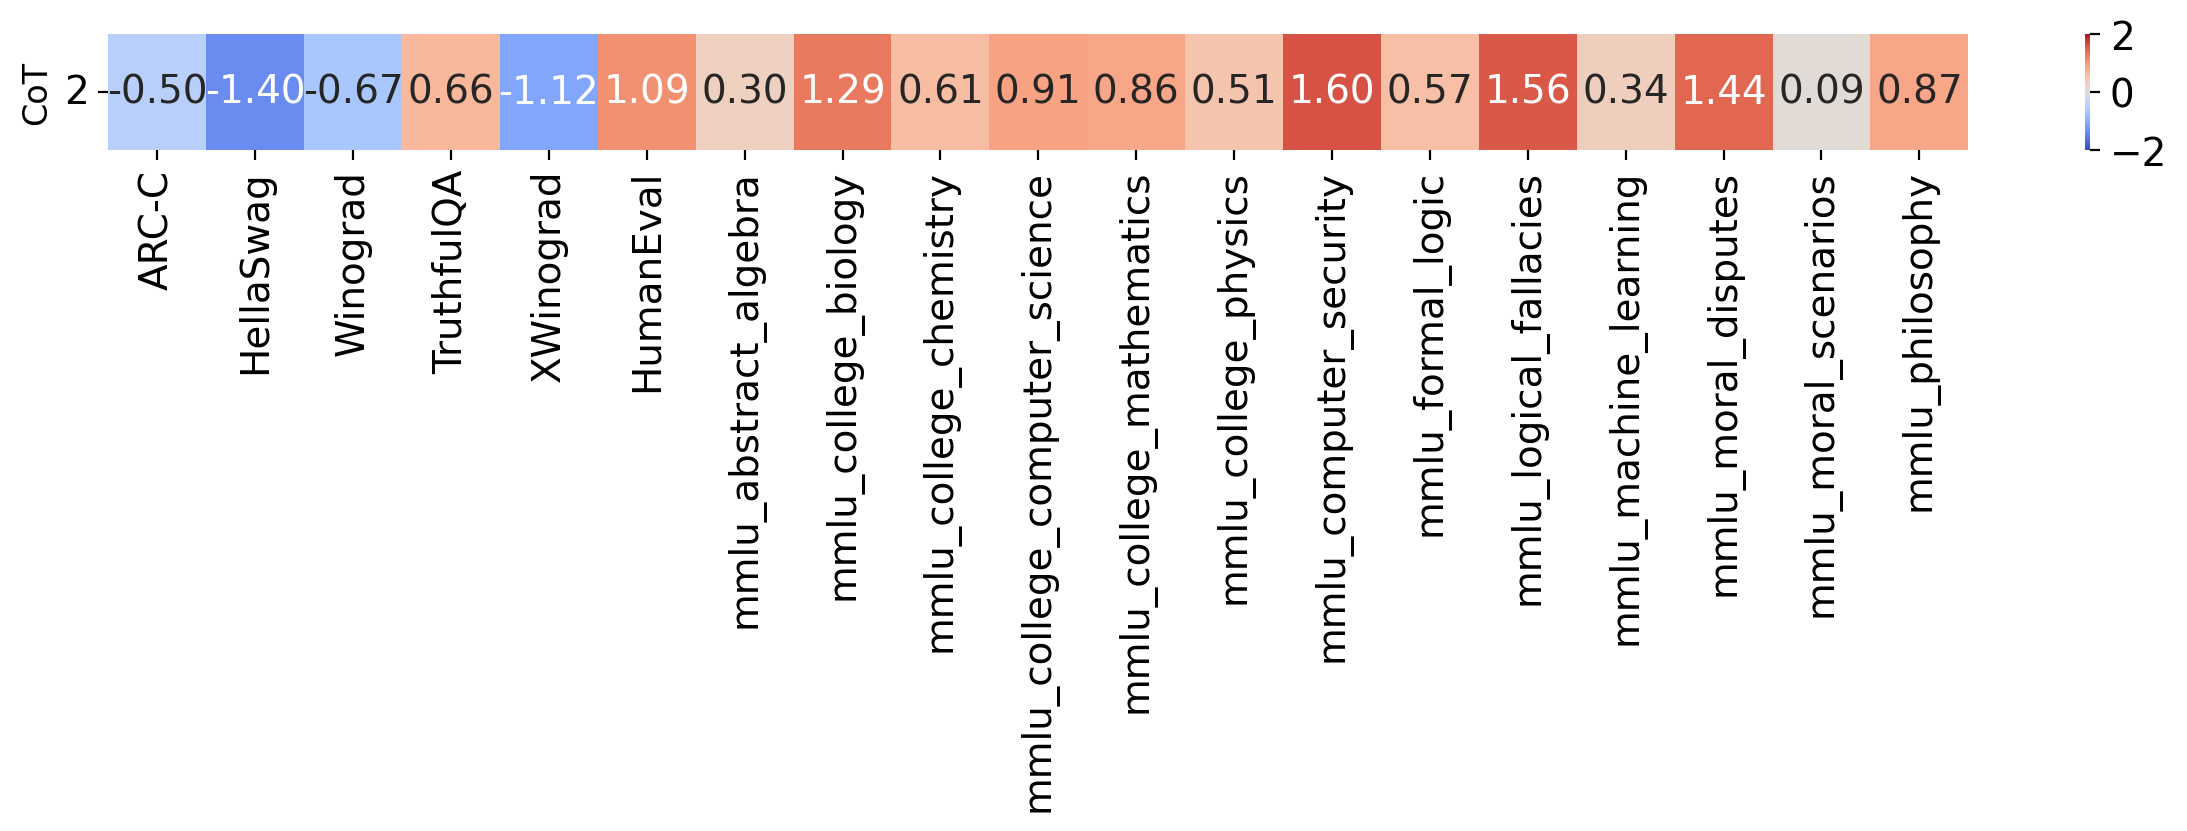

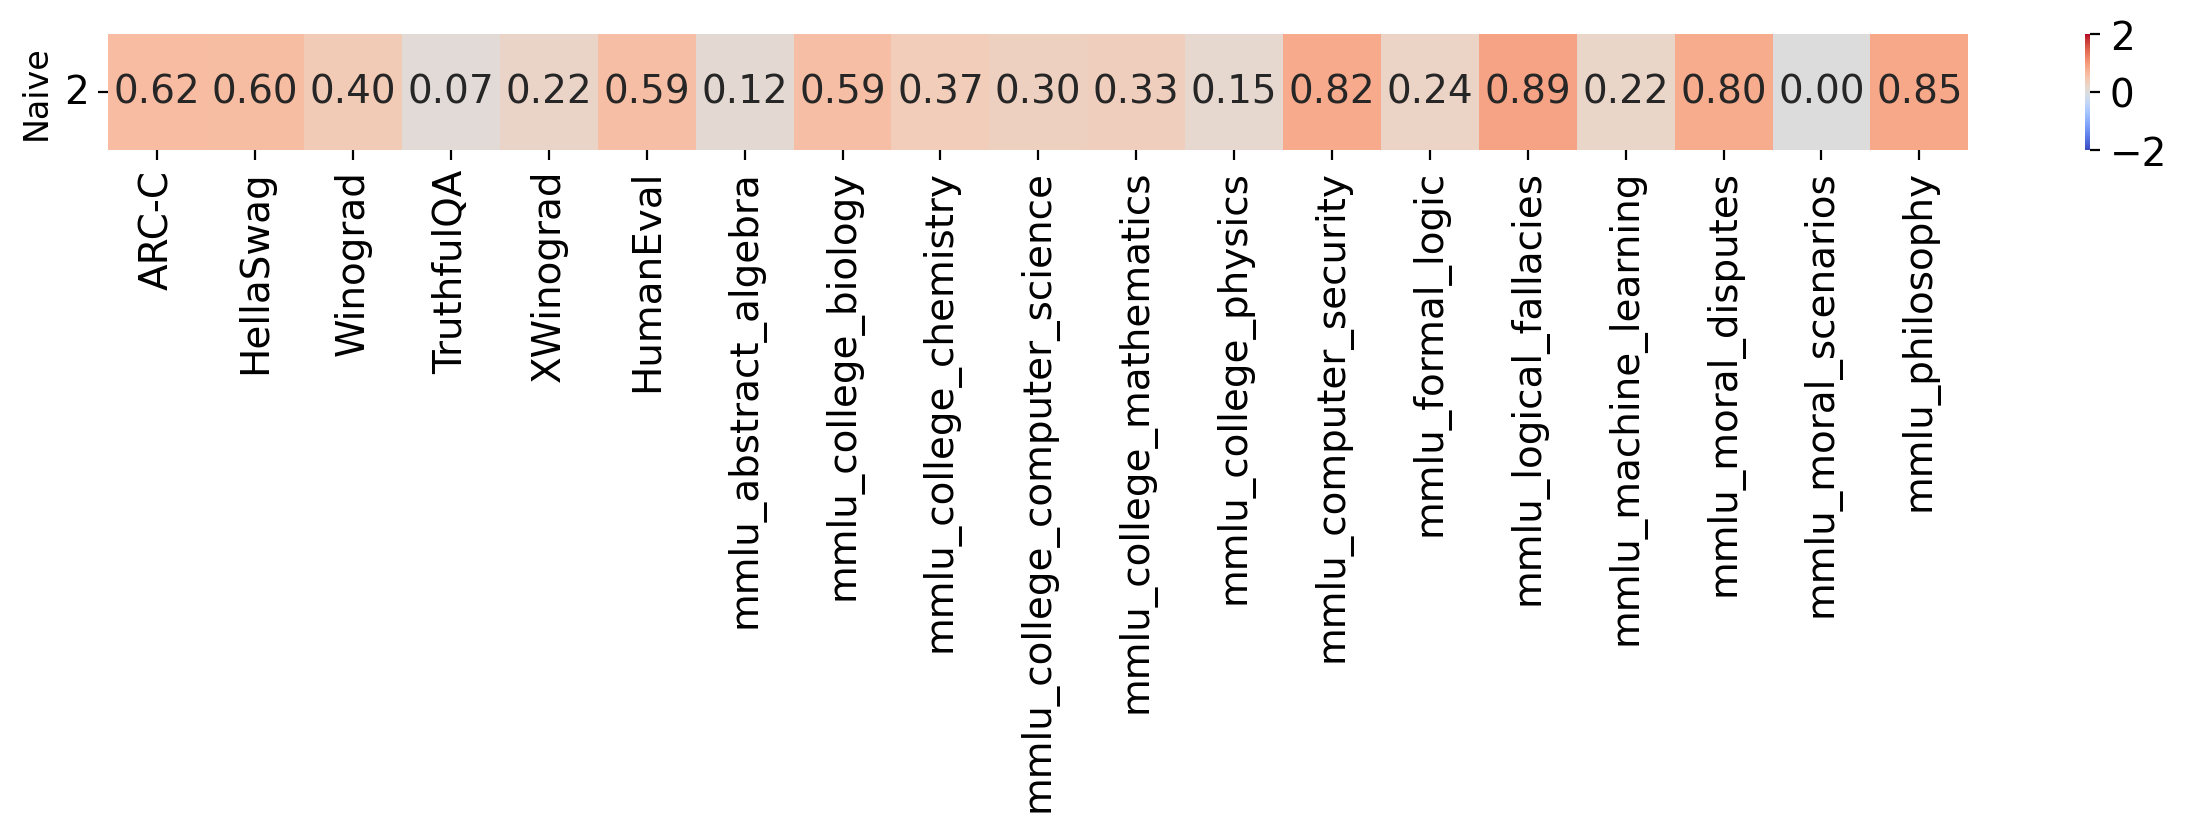

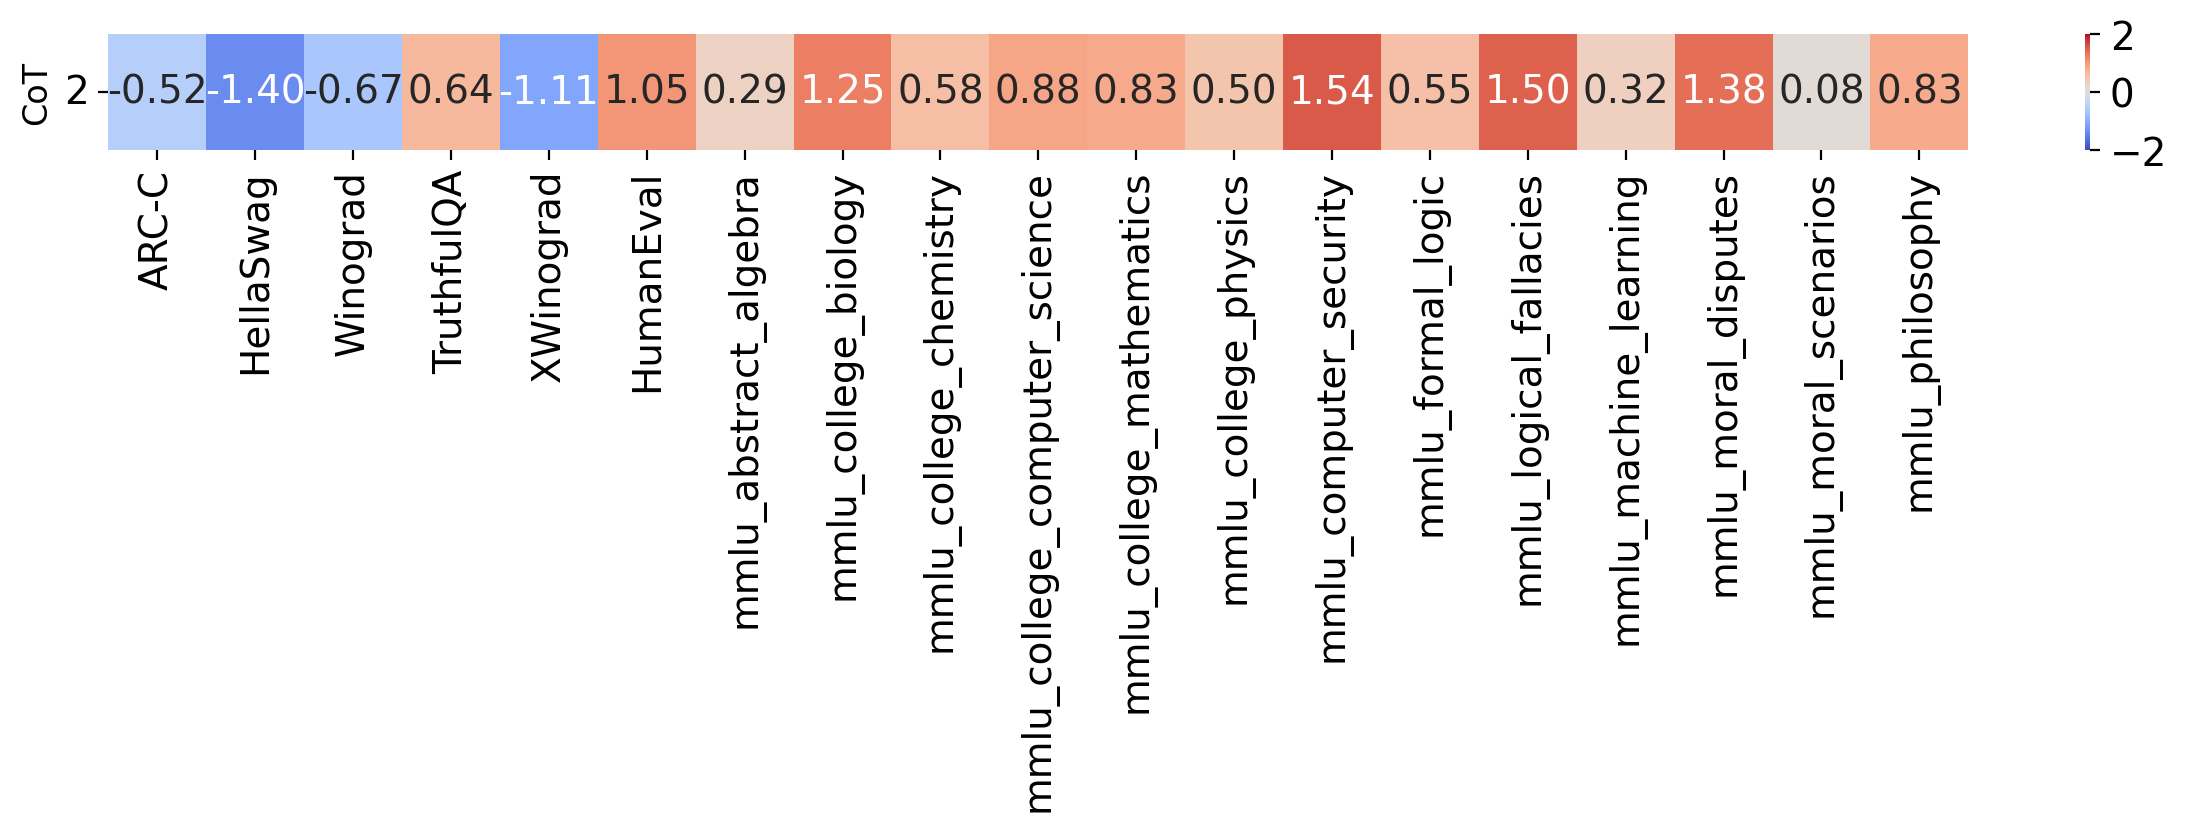

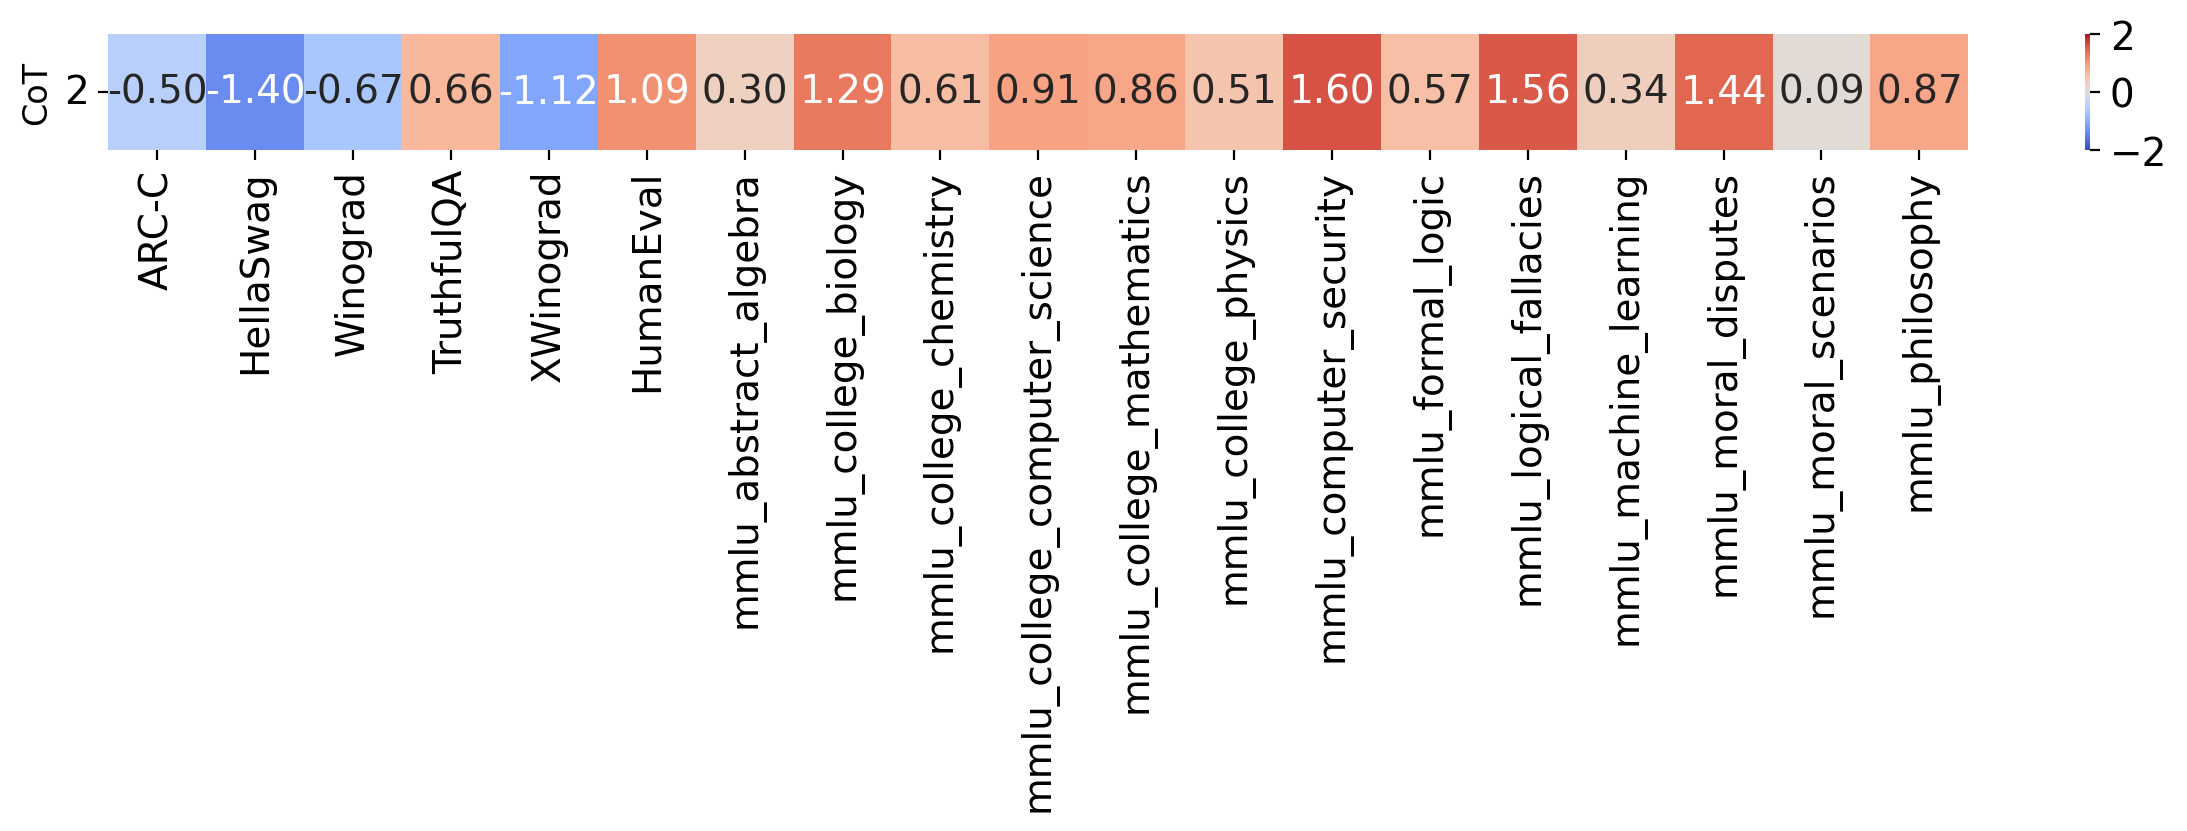

In [10]:
plot_weight_analysis(
    merged_eval, 
    y_metrics=GSM8K_METHOD_SCALING_METRICS, 
    x_metrics_list=[PC_METRIC_NUM_2], 
    analysis_setup_kwargs=SCALING_SETUP_KWARGS, 
    #y_metric_specific_kwargs=None, 
    #filter_model_family=EVAL_BASE_MODEL_FAMILIES, # not default
    norm_weights=False,
    remove_y_ticks=False,
    figsize=15,
    rotationx=90,
    cmap='coolwarm',
    v=2
)

## BBH Tracking shuffled objects

In [12]:
GSM8K_COT_SCALING_METRICS, SCALING_SETUP_KWARGS, GSM8K_SETUP_SPECIFIC_KWARGS, GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, GSM8K_METHOD_SCALING_COLOR_MAP = get_bbh_subtask_scaling_metrics(task='tracking_shuffled_objects_seven_objects',
                                                                                                                                                                                     mmlu_subtasks=mmlu_subtasks)

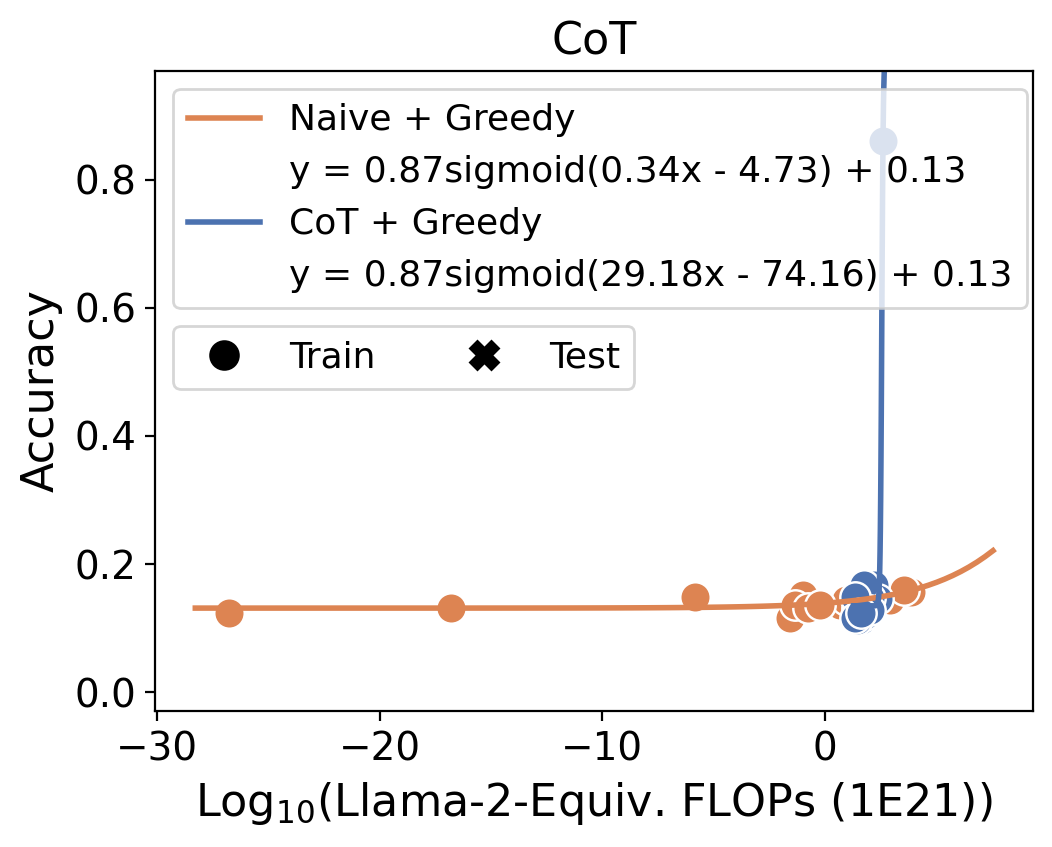

In [13]:
fig, fit_results = plot_scaling_comparison_multi_metrics(
    merged_eval, 
    y_metric_list=GSM8K_COT_SCALING_METRICS, 
    x_metrics_list=[PC_METRIC_NUM_3], 
    analysis_setup_kwargs=SCALING_SETUP_KWARGS, 
    y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, 
    ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
    plot_title="CoT"
)

/scratch2/jsalle/ObsScaling/utils/plot.py:809: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


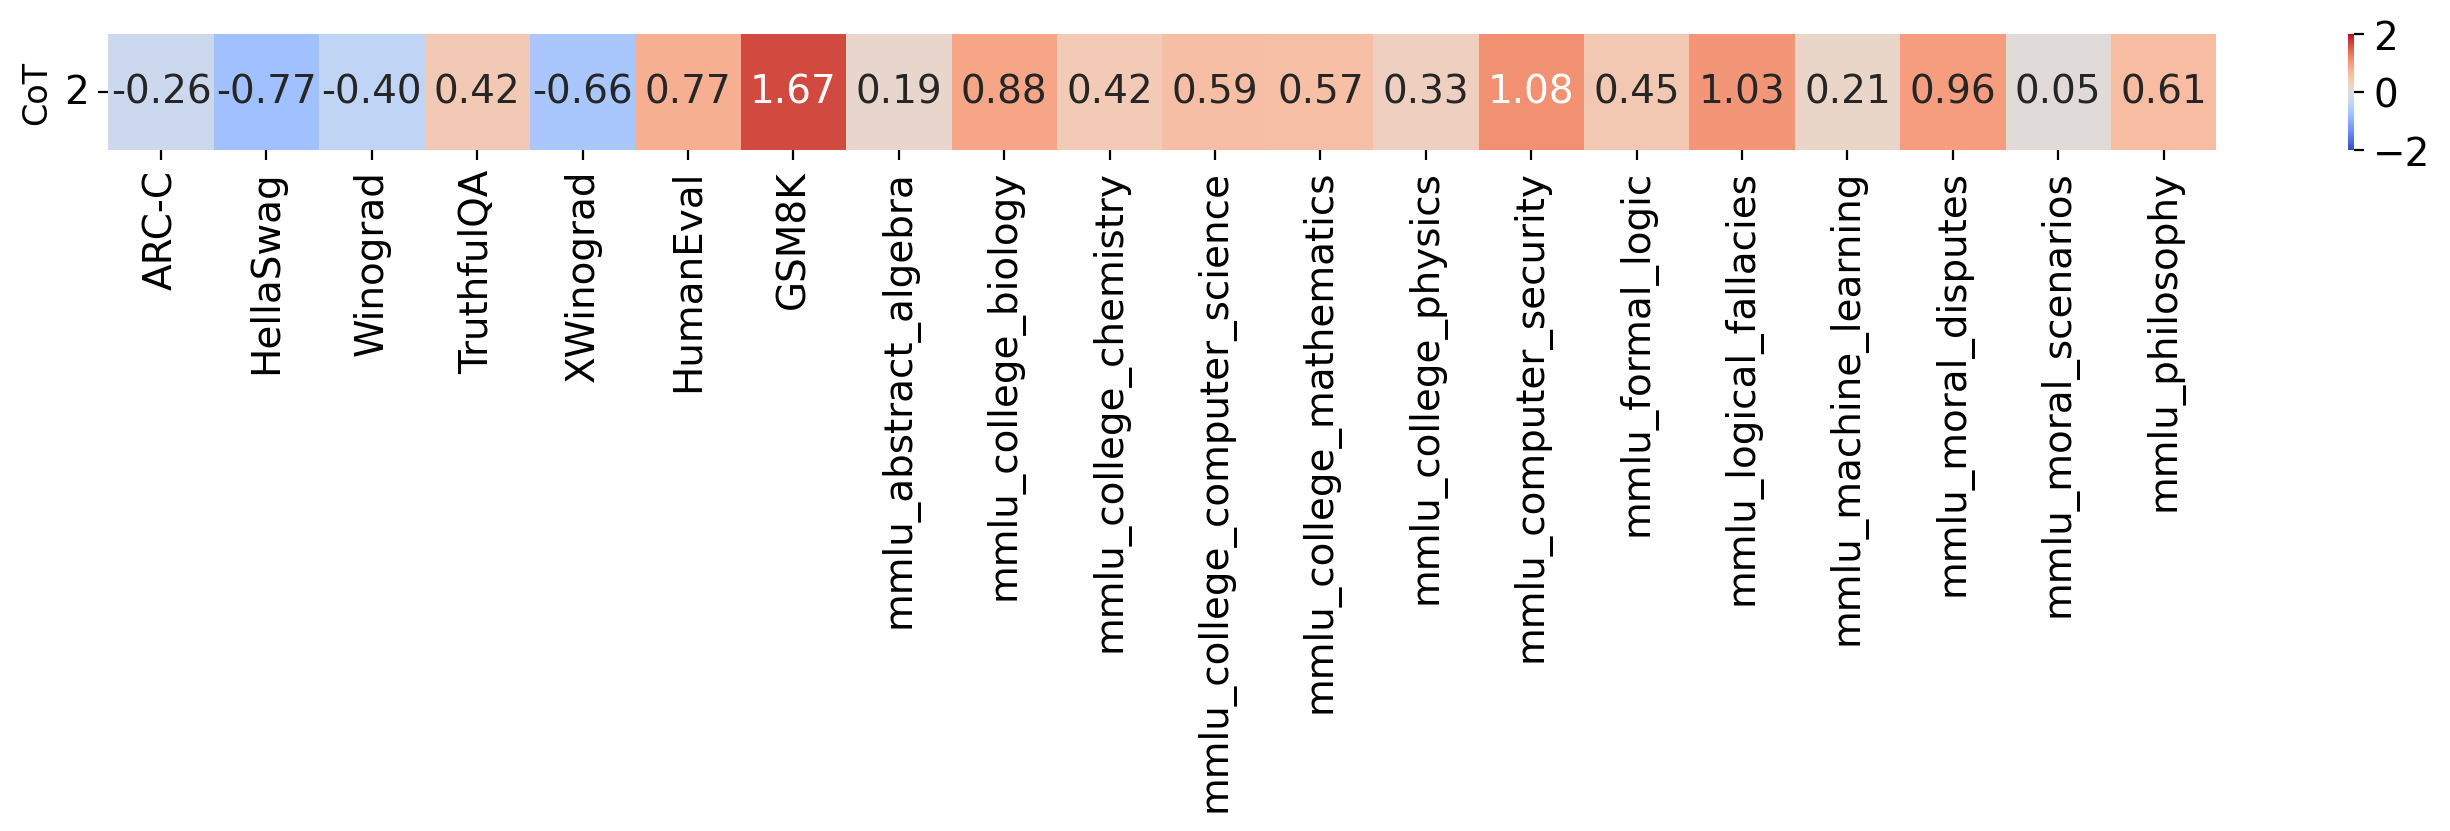

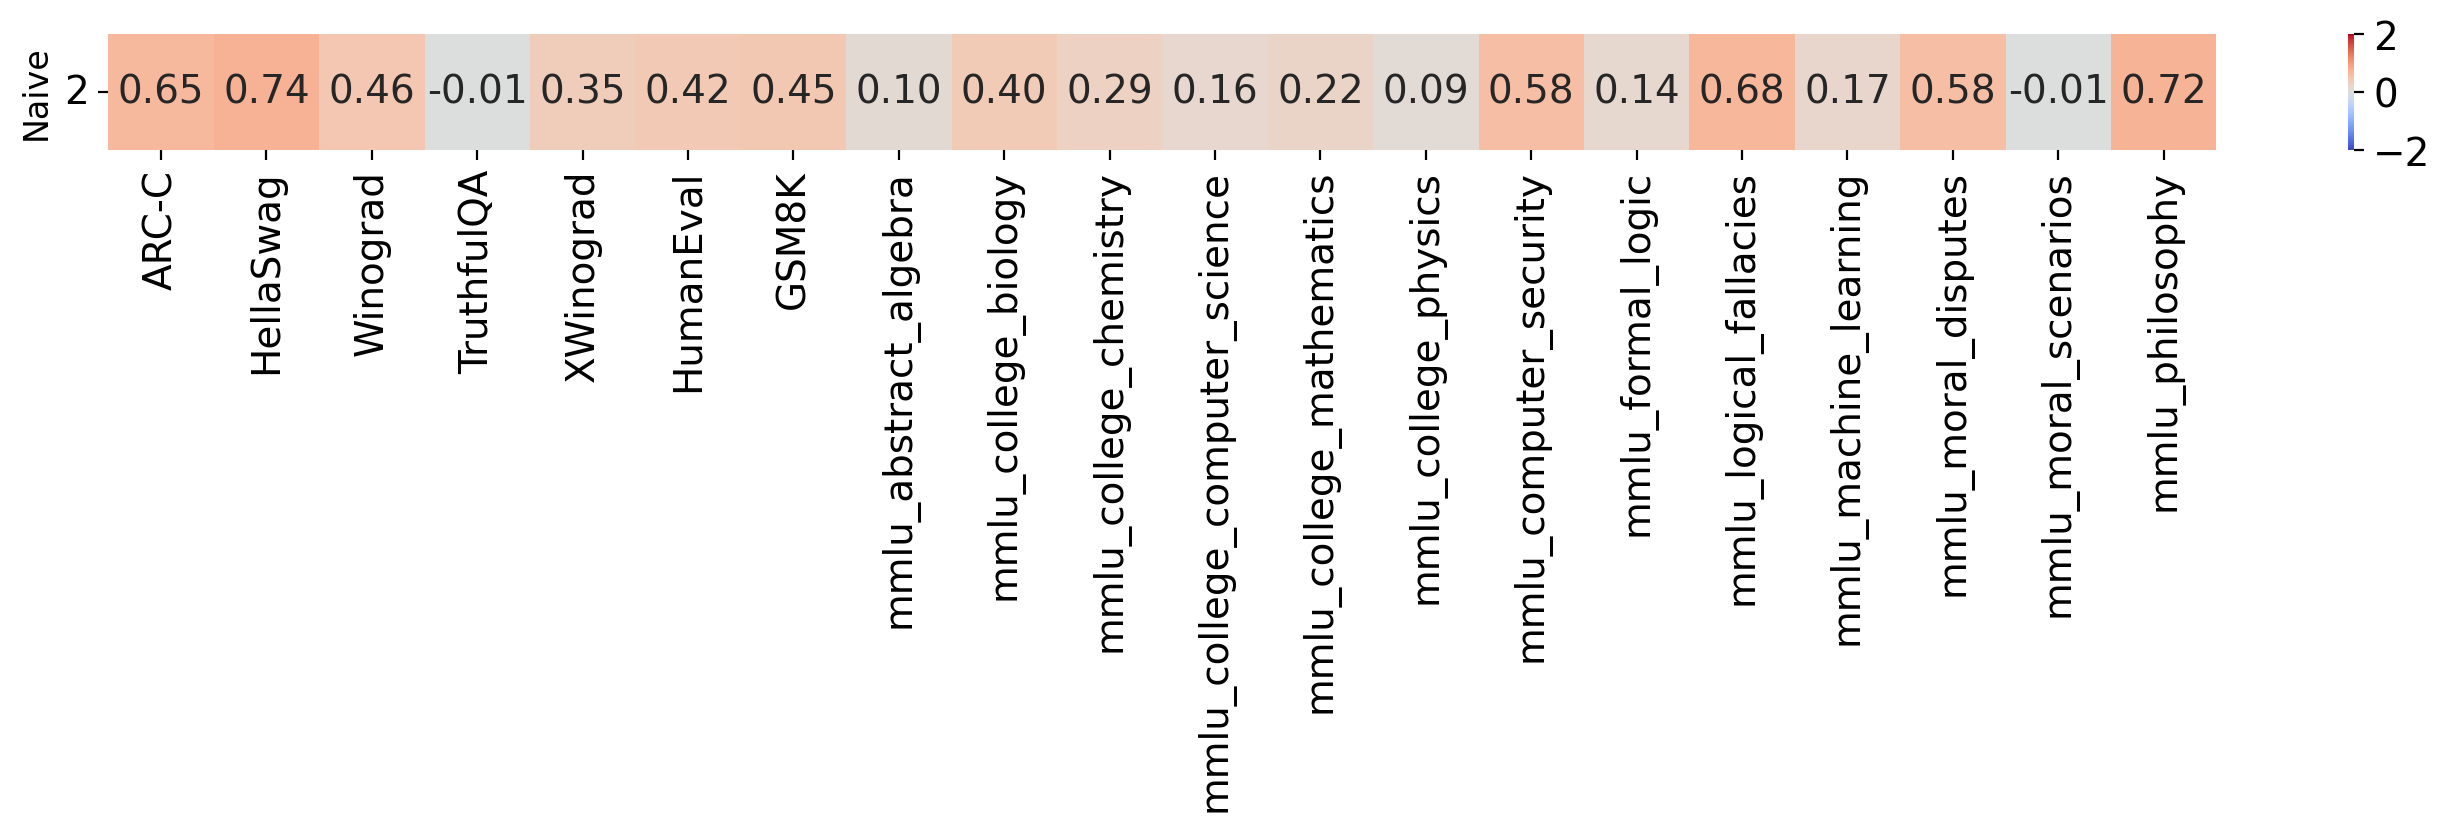

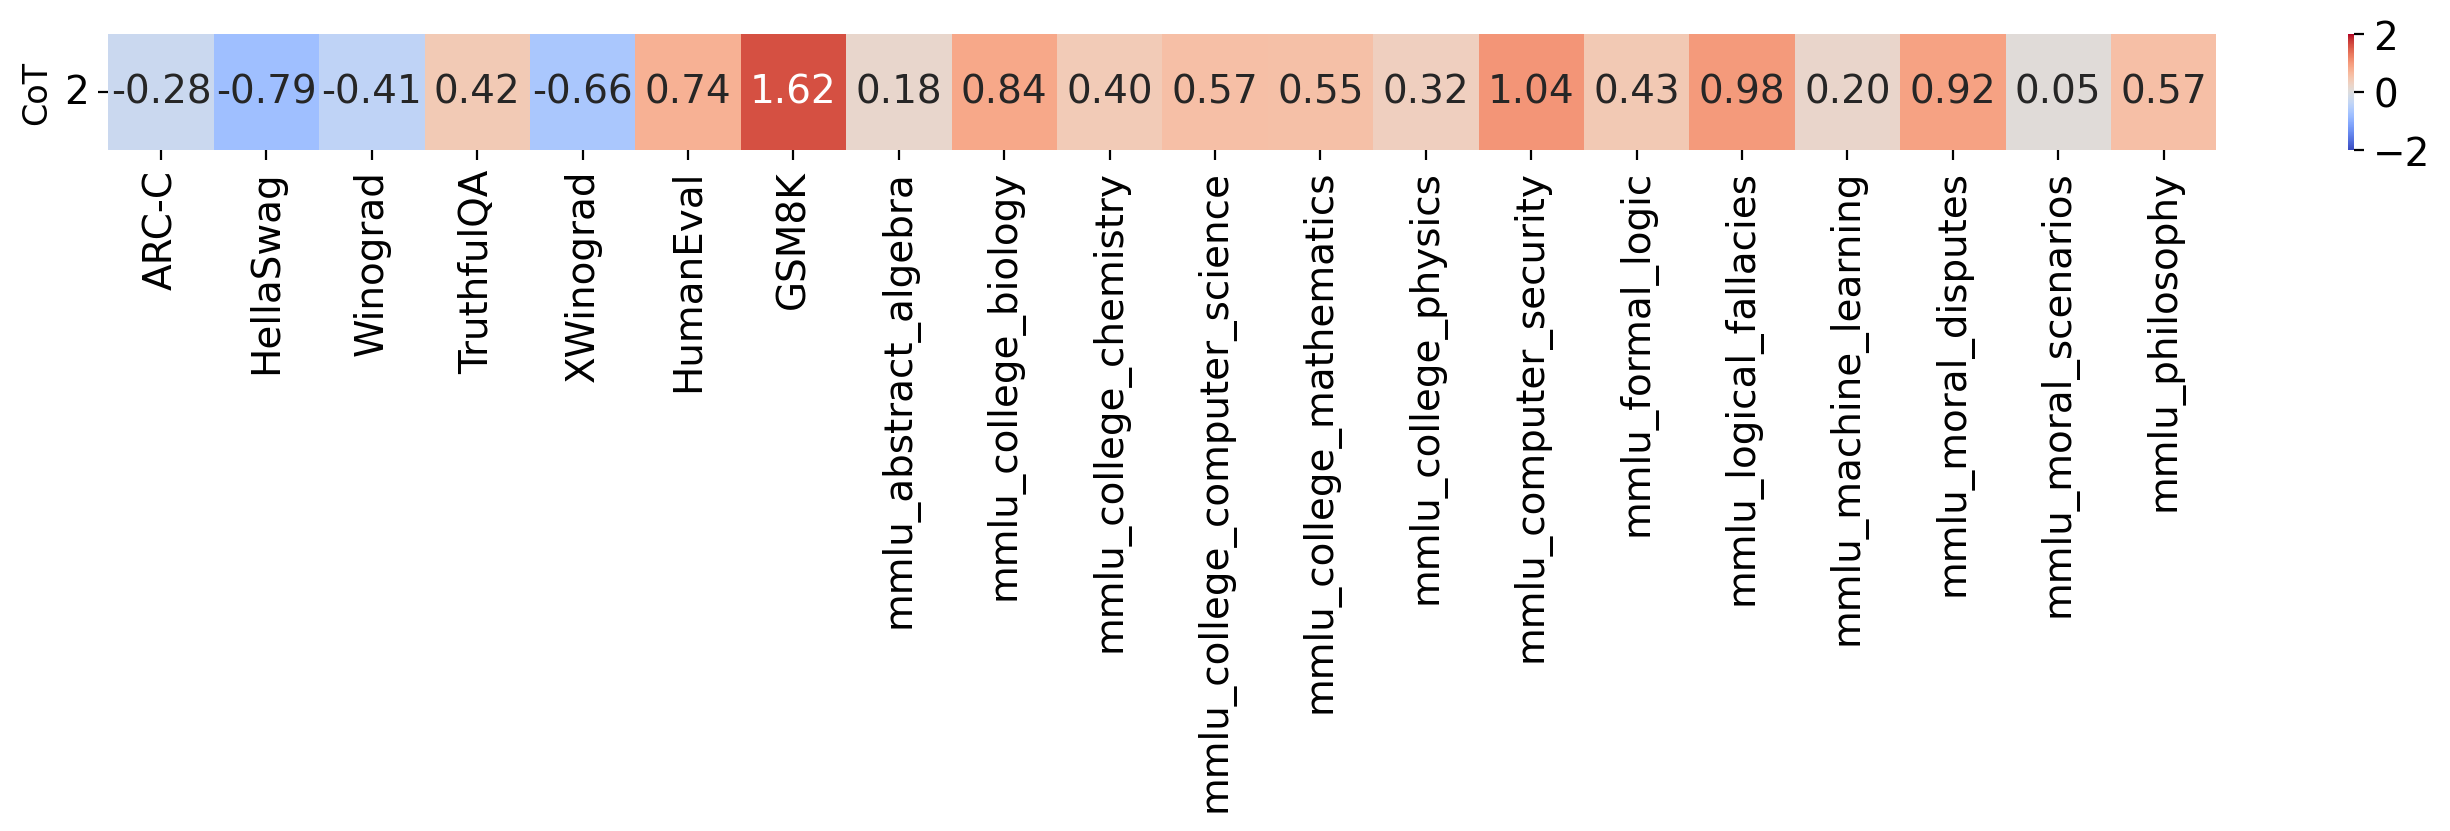

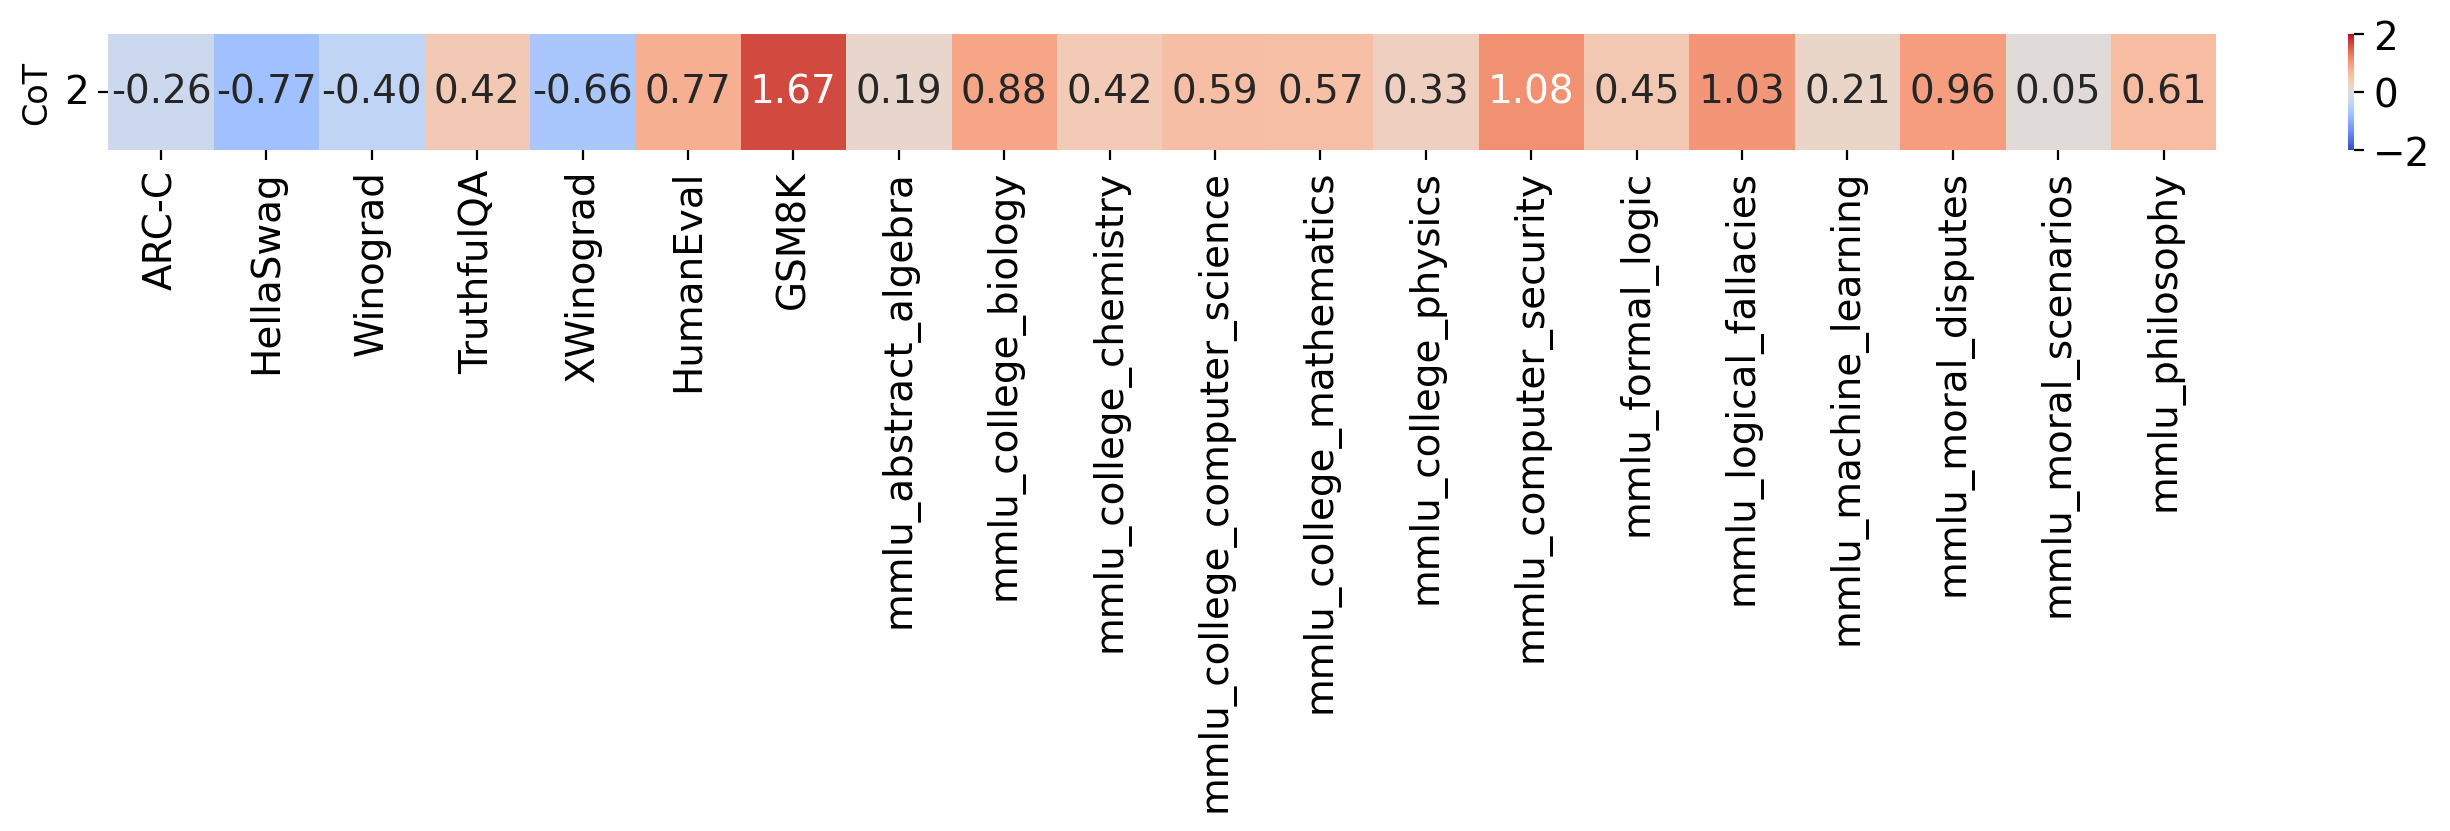

In [15]:
plot_weight_analysis(
    merged_eval, 
    y_metrics=GSM8K_METHOD_SCALING_METRICS, 
    x_metrics_list=[PC_METRIC_NUM_2], 
    analysis_setup_kwargs=SCALING_SETUP_KWARGS, 
    #y_metric_specific_kwargs=None, 
    #filter_model_family=EVAL_BASE_MODEL_FAMILIES, # not default
    norm_weights=False,
    remove_y_ticks=False,
    figsize=17,
    rotationx=90,
    cmap='coolwarm',
    v=2
)